# Batches and dataloaders

One of the handy options about using pytorch is that it can handle batches almost automatically.

This is useful because instead of doing the optimization step over all the dataset we can do it over the batches.

Also we will look in a way to prevent overfitting, using splits of the data, train, validation and test.

In [128]:
import torch 
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.datasets import load_wine
import torch.nn as nn 

In [129]:
X, y = load_wine(return_X_y=True)
print(f"X shape: {X.shape}") #samples, features
print(f"y shape: {y.shape}") 

X shape: (178, 13)
y shape: (178,)


We can use pytorch to load our data in a smart way:

1. We will create a Dataset object inheriting the Dataset module.
2. We will define 3 main functions inside of it:
    1. **init:** constructor of the class
    2. **getitem:** we will have the ability to select entries of the tensor
    3. **len:** it will return the size of the object

In [130]:
class WineData(Dataset):
    def __init__(self):
        x, y = load_wine(return_X_y=True)
        self.x = torch.from_numpy(x.astype(np.float32)) #remember that float32 is the standard dtype in torch
        self.y = torch.from_numpy(y[:,np.newaxis].astype(np.float32)) #pytorch doesnt like empty axis (x,) -> (x,1)
        self.n_samples = x.shape[0]
    def __getitem__(self,index):
        return self.x[index], self.y[index]
    def __len__(self):
        return self.n_samples

In [131]:
dataset = WineData()
dataset[0]

(tensor([1.4230e+01, 1.7100e+00, 2.4300e+00, 1.5600e+01, 1.2700e+02, 2.8000e+00,
         3.0600e+00, 2.8000e-01, 2.2900e+00, 5.6400e+00, 1.0400e+00, 3.9200e+00,
         1.0650e+03]),
 tensor([0.]))

## Why we did all of this? 

Well, now that we have a dataset object we can use the dataloader from torch to work directly with batches, and shuffling the data on the go.

In [132]:
dataloader = DataLoader(dataset=dataset,batch_size=6,shuffle=True)

In [133]:
num_epochs = 3

In [134]:
for epoch in range(num_epochs):
    for i, (inputs,labels) in enumerate(dataloader):
        if (i+1) % 10 == 0:
            print(f'epoch: {epoch+1}/{num_epochs}')
            print(f'step: {i+1}')

epoch: 1/3
step: 10
epoch: 1/3
step: 20
epoch: 1/3
step: 30
epoch: 2/3
step: 10
epoch: 2/3
step: 20
epoch: 2/3
step: 30
epoch: 3/3
step: 10
epoch: 3/3
step: 20
epoch: 3/3
step: 30


# Full Feedforward net example 

### First we will set up our device:

In [135]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


We will use the MNIST dataset since it is easy to load it.

In [136]:
train_data = torchvision.datasets.MNIST(root='./dataset', 
train = True, transform = transforms.ToTensor(), download = True)

In [137]:
test_data = torchvision.datasets.MNIST(root='./dataset', 
train = False, transform = transforms.ToTensor())

We will set up all our hyperparameters and use a DataLoader:

In [138]:
input_size = 784 # we know that images are 28x28
hidden_size = 20
n_class = 10 # 10 digits
n_epochs = 4
batch_size = 100
lr = 0.001

In [139]:
train_loader = torch.utils.data.DataLoader(dataset=train_data,
batch_size = batch_size, shuffle= True)

test_loader = torch.utils.data.DataLoader(dataset=test_data,
batch_size = batch_size, shuffle= False)

Lets verify our data with a visualization, DataLoader object is a iterator so:

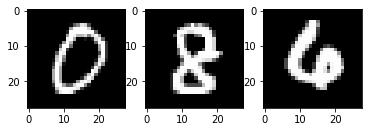

In [140]:
import matplotlib.pyplot as plt
data = iter(train_loader)
samples, labels = data.next() # we unpack next values
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(samples[i,0],cmap='gray')

Our data is correctly loaded, we need to specify our model and train it.

In [141]:
class NNet(nn.Module):
    def __init__(self,input_size,hidden_size,n_class):
        super(NNet, self).__init__()
        self.l1 = nn.Linear(input_size,hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size,n_class)

    def forward(self,x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        return out 

model = NNet(input_size, hidden_size, n_class)
model = model.to(device) # We need to push all the parameters of the model to the GPU!!!


Once defined we should specify our loss and optimizer

In [142]:
crit = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr = lr)

Finally our training loop:

* Some remarks:
    * We need to reshape our data since our specified `input_size= 784`
    * We will be pushing tensor to gpu (`device`), for the first time
    * try to remember everything reviewed at the first two notebooks at this point

In [143]:
n_total = len(train_loader)
for epoch in range(n_epochs):
    for i, (images,labels) in enumerate(train_loader):
        images = images.reshape(-1,784).to(device)
        labels = labels.to(device)

        outpt = model(images)
        loss = crit(outpt,labels)

        optim.zero_grad()
        loss.backward()
        optim.step()

        if (i+1) % 300 == 0:
            print(f'epoch: {epoch+1}|{n_epochs},step: {i+1}|{n_total}')
            print(f'loss: {loss.item():.2f}')

epoch: 1|4,step: 300|600
loss: 0.26
epoch: 1|4,step: 600|600
loss: 0.38
epoch: 2|4,step: 300|600
loss: 0.39
epoch: 2|4,step: 600|600
loss: 0.20
epoch: 3|4,step: 300|600
loss: 0.25
epoch: 3|4,step: 600|600
loss: 0.25
epoch: 4|4,step: 300|600
loss: 0.24
epoch: 4|4,step: 600|600
loss: 0.11


Next the test loop, why we are using the `torch.no_grad()`
here?

In [144]:
with torch.no_grad():
    n_samples = 0
    n_correct = 0
    for images, labels in test_loader:
        images = images.reshape(-1,784).to(device)
        labels = labels.to(device)
        out = model(images)
        _,predictions = torch.max(out,1)
        n_samples+=labels.shape[0]
        n_correct+=(predictions==labels).sum().item()
    acc = n_correct/n_samples * 100.0

    print(f'test accuracy: {acc}')

test accuracy: 93.76


So it seems that it is working!!! 

Next we will review a tool called **tensorboard** and how to save our models.